In [1]:
import ROOT
import numpy as np
import uproot3
import time
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

Welcome to JupyROOT 6.24/02


In [2]:
root_file = "dav10.root"
file = uproot3.open(root_file)
file.keys()

[b'Truth_Vertex_PV_Selected;6',
 b'Truth_Vertex_PV_Selected;5',
 b'Reco_Vertex;4',
 b'Reco_Vertex;3',
 b'amvf;1']

In [3]:
tree_truth = file['Truth_Vertex_PV_Selected;6']
tree_reco = file['Reco_Vertex;4']
branches_truth = tree_truth.arrays(namedecode='utf-8')
branches_reco = tree_reco.arrays(namedecode='utf-8')
branches_truth.keys(), branches_reco.keys()

(dict_keys(['event_id', 'truth_vtx_vx', 'truth_vtx_vy', 'truth_vtx_vz', 'truth_particle_Id', 'truth_particle_Type', 'truth_particle_process', 'truth_particle_vx', 'truth_particle_vy', 'truth_particle_vz', 'truth_particle_vt', 'truth_particle_p', 'truth_particle_px', 'truth_particle_py', 'truth_particle_pz', 'truth_particle_m', 'truth_particle_q', 'truth_particle_eta', 'truth_particle_phi', 'truth_particle_pt', 'truth_particle_vertexPrimary', 'truth_particle_vertexSecondary', 'truth_particle_particle', 'truth_particle_generation', 'truth_particle_subParticle', 'truth_vtx_fitted_trk_d0', 'truth_vtx_fitted_trk_z0', 'truth_vtx_fitted_trk_phi', 'truth_vtx_fitted_trk_theta', 'truth_vtx_fitted_trk_qp', 'truth_vtx_fitted_trk_time', 'truth_vtx_fitted_trk_err_d0', 'truth_vtx_fitted_trk_err_z0', 'truth_vtx_fitted_trk_err_phi', 'truth_vtx_fitted_trk_err_theta', 'truth_vtx_fitted_trk_err_qp', 'truth_vtx_fitted_trk_err_time', 'truth_vtx_fitted_trk_vtxID']),
 dict_keys(['event_id', 'reco_vtx_vx', 're

In [4]:
# define variables
event_size = 10000
truth_vx, truth_vy, truth_vz = branches_truth['truth_vtx_vx'], branches_truth['truth_vtx_vy'], branches_truth['truth_vtx_vz']
reco_vx, reco_vy, reco_vz = branches_reco['reco_vtx_vx'], branches_reco['reco_vtx_vy'], branches_reco['reco_vtx_vz']
truth_d0, truth_z0, truth_phi, truth_theta, truth_qp, truth_trk_vtxid = branches_truth['truth_vtx_fitted_trk_d0'], branches_truth['truth_vtx_fitted_trk_z0'], branches_truth['truth_vtx_fitted_trk_phi'], branches_truth['truth_vtx_fitted_trk_theta'], branches_truth['truth_vtx_fitted_trk_qp'], branches_truth['truth_vtx_fitted_trk_vtxID']
reco_d0, reco_z0, reco_phi, reco_theta, reco_qp, reco_trk_trackweight, reco_trk_vtxid  = branches_reco['reco_vtx_fitted_trk_d0'], branches_reco['reco_vtx_fitted_trk_z0'], branches_reco['reco_vtx_fitted_trk_phi'], branches_reco['reco_vtx_fitted_trk_theta'], branches_reco['reco_vtx_fitted_trk_qp'], branches_reco['reco_vtx_fitted_trk_trackWeight'], branches_reco['reco_vtx_fitted_trk_vtxID']

In [5]:
# prepare data
truth_trk_info, reco_trk_info, truth_vtx_info, reco_vtx_info, truth_HSvtx, reco_HSvtx, truth_HStrk, reco_HStrk, reco_trkweight, reco_HStrkweight = [], [], [], [], [], [], [], [], [], []
num_vtx_reco, num_vtx_truth, num_trk_reco, num_trk_truth = [], [], [], []

for i in tqdm(range(event_size)):
    num_trk_truth_i = np.bincount(truth_trk_vtxid[i])
    truth_trk_info_tmp = np.vstack([truth_d0[i], truth_z0[i], truth_phi[i], truth_theta[i], truth_qp[i]]).transpose()
    truth_trk_info_tmp = np.split(truth_trk_info_tmp, np.cumsum(num_trk_truth_i))
    truth_trk_info_tmp = truth_trk_info_tmp[:-1]
    truth_trk_info.append(truth_trk_info_tmp)
    num_trk_truth.append(num_trk_truth_i)
    
    num_trk_reco_i = np.bincount(reco_trk_vtxid[i])
    reco_trk_info_tmp = np.vstack([reco_d0[i], reco_z0[i], reco_phi[i], reco_theta[i], reco_qp[i]]).transpose()
    reco_trk_info_tmp, reco_trkweight_tmp = np.split(reco_trk_info_tmp, np.cumsum(num_trk_reco_i)), np.split(reco_trk_trackweight[i], np.cumsum(num_trk_reco_i))
    reco_trk_info_tmp, reco_trkweight_tmp = reco_trk_info_tmp[:-1], reco_trkweight_tmp[:-1]
    reco_trk_info.append(reco_trk_info_tmp)
    num_trk_reco.append(num_trk_reco_i)
    reco_trkweight.append(reco_trkweight_tmp)
    
    truth_vtx_i = np.vstack([truth_vx[i], truth_vy[i], truth_vz[i]]).transpose().tolist()
    truth_HSvtx.append(truth_vtx_i[0])
    truth_HStrk.append(truth_trk_info_tmp[0])
    truth_vtx_info.append(truth_vtx_i)
    num_vtx_truth.append(len(truth_vtx_i))
    
    reco_vtx_i = np.vstack([reco_vx[i], reco_vy[i], reco_vz[i]]).transpose().tolist()
    reco_pt = np.split((1/(np.abs(reco_qp[i])) * np.sin(reco_theta[i])) ** 2, np.cumsum(num_trk_reco_i))
    reco_pt = [sum(i) for i in reco_pt[:-1]]
    reco_HSvtx.append(reco_vtx_i[reco_pt.index(max(reco_pt))])
    reco_HStrk.append(reco_trk_info_tmp[reco_pt.index(max(reco_pt))])
    reco_HStrkweight.append(reco_trkweight_tmp[reco_pt.index(max(reco_pt))])
    reco_vtx_info.append(reco_vtx_i)
    num_vtx_reco.append(len(reco_vtx_i))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1372.96it/s]


In [120]:
# testing
reco_trkweight[0]

[array([9.88566410e-01, 9.87810161e-01, 9.47470630e-01, 9.69525072e-01,
        9.78670707e-01, 8.60691675e-01, 1.74126573e-01, 9.58793326e-01,
        9.84907309e-01, 9.79034158e-01, 9.86050666e-01, 9.85976238e-01,
        9.86656022e-01, 9.44598603e-01, 9.86267373e-01, 9.50559347e-01,
        9.47286085e-01, 9.82412112e-01, 1.81086406e-01, 8.54028482e-05,
        1.53337064e-01, 4.59611369e-03, 9.62186399e-01, 9.79915841e-01,
        9.85530251e-01, 6.43146018e-01, 9.81499539e-01, 9.81621494e-01,
        9.74585738e-01, 4.24549329e-05, 6.28864582e-01, 9.88673761e-01,
        9.88650393e-01, 8.83241159e-01, 9.74451750e-01, 9.11215275e-01,
        9.72576996e-01, 9.17060448e-01, 9.59265494e-01, 9.67365677e-01,
        9.88671031e-01, 3.52208921e-01, 9.81388040e-01, 9.87079846e-01,
        9.87720272e-01, 9.74507872e-01, 7.75426641e-01, 9.65336050e-01,
        9.67580673e-01, 8.71503998e-01]),
 array([1.27846130e-07, 3.15375041e-04, 9.74936715e-01, 9.40564537e-01,
        2.76375216e-02

In [99]:
num_vtx_reco[0]

3

## Plotting x-position, y-position, z-position, number of vertex, number of track

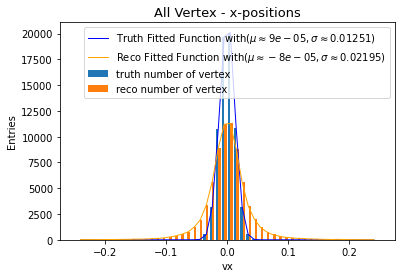

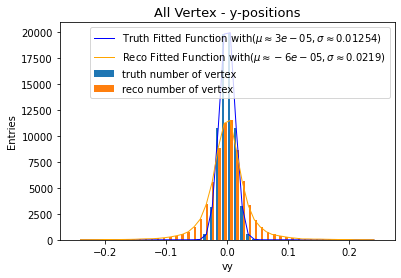

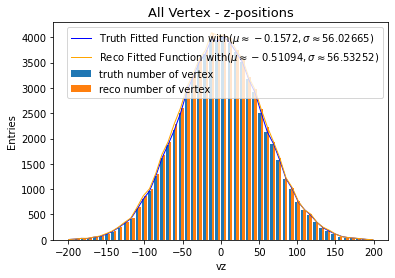

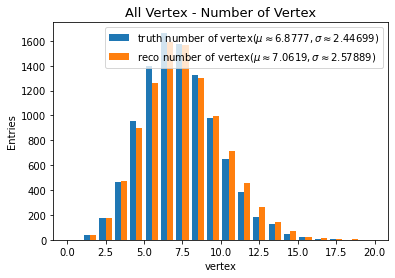

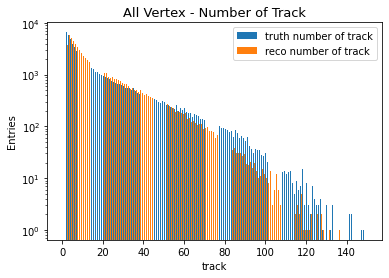

In [7]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = scipy.optimize.curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt
        
# define the plots
fig_vx, ax_vx = plt.subplots()
fig_vy, ax_vy = plt.subplots()
fig_vz, ax_vz = plt.subplots()
fig_vtx, ax_vtx = plt.subplots()
fig_trk, ax_trk = plt.subplots()
                    
# vx
ax_vx.hist([truth_vx.flatten(), reco_vx.flatten()], bins=50,
           range=(-0.25, 0.25), label=['truth number of vertex', 'reco number of vertex'])

# vx fitted function
xdata = np.linspace(-0.24, 0.24, 50)
counts, bins = np.histogram(truth_vx.flatten(), bins=50, range=(-0.25, 0.25))
H, A, x0, sigma = gauss_fit(xdata, counts)
ax_vx.plot(xdata, counts, color='blue', linewidth=1, 
           label='Truth Fitted Function with' + f'$(\\mu \\approx {round(x0, 5)}, \\sigma \\approx {round(np.abs(sigma), 5)})$')

counts, bins = np.histogram(reco_vx.flatten(), bins=50, range=(-0.25, 0.25))
H, A, x0, sigma = gauss_fit(xdata, counts)
ax_vx.plot(xdata, counts, color='orange', linewidth=1,
           label='Reco Fitted Function with' + f'$(\\mu \\approx {round(x0, 5)}, \\sigma \\approx {round(np.abs(sigma), 5)})$')

# vy
ax_vy.hist([truth_vy.flatten(), reco_vy.flatten()], bins=50, 
           range=(-0.25, 0.25), label=['truth number of vertex', 'reco number of vertex'])

# vy fitted function
xdata = np.linspace(-0.24, 0.24, 50)
counts, bins = np.histogram(truth_vy.flatten(), bins=50, range=(-0.25, 0.25))
H, A, x0, sigma = gauss_fit(xdata, counts)
ax_vy.plot(xdata, counts, color='blue', linewidth=1, 
           label='Truth Fitted Function with' + f'$(\\mu \\approx {round(x0, 5)}, \\sigma \\approx {round(np.abs(sigma), 5)})$')

counts, bins = np.histogram(reco_vy.flatten(), bins=50, range=(-0.25, 0.25))
H, A, x0, sigma = gauss_fit(xdata, counts)
ax_vy.plot(xdata, counts, color='orange', linewidth=1,
           label='Reco Fitted Function with' + f'$(\\mu \\approx {round(x0, 5)}, \\sigma \\approx {round(np.abs(sigma), 5)})$')

# vz
ax_vz.hist([truth_vz.flatten(), reco_vz.flatten()], bins=50,
           range=(-200, 200), label=['truth number of vertex', 'reco number of vertex'])

# vz fitted function
xdata = np.linspace(-199, 199, 50)
counts, bins = np.histogram(truth_vz.flatten(), bins=50, range=(-200, 200))
H, A, x0, sigma = gauss_fit(xdata, counts)
ax_vz.plot(xdata, counts, color='blue', linewidth=1, 
           label='Truth Fitted Function with' + f'$(\\mu \\approx {round(x0, 5)}, \\sigma \\approx {round(np.abs(sigma), 5)})$')

counts, bins = np.histogram(reco_vz.flatten(), bins=50, range=(-200, 200))
H, A, x0, sigma = gauss_fit(xdata, counts)
ax_vz.plot(xdata, counts, color='orange', linewidth=1,
           label='Reco Fitted Function with' + f'$(\\mu \\approx {round(x0, 5)}, \\sigma \\approx {round(np.abs(sigma), 5)})$')

# num of vtx
mu_truth, sigma_truth = scipy.stats.norm.fit(num_vtx_truth)
mu_reco, sigma_reco = scipy.stats.norm.fit(num_vtx_reco)
ax_vtx.hist([num_vtx_truth, num_vtx_reco], bins=20, range=(0, 20), 
            label=['truth number of vertex' + f'$(\\mu \\approx {round(mu_truth, 5)}, \\sigma \\approx {round(np.abs(sigma_truth), 5)})$', 
                   'reco number of vertex' + f'$(\\mu \\approx {round(mu_reco, 5)}, \\sigma \\approx {round(np.abs(sigma_reco), 5)})$'])

# num of trk
ax_trk.hist([list(np.concatenate(num_trk_truth).flat), list(np.concatenate(num_trk_reco).flat)], bins=150,
            range=(0, 150), label=['truth number of track', 'reco number of track'])
ax_trk.set_yscale('log')


ax_vx.set_title('All Vertex - x-positions', fontsize=13)
ax_vy.set_title('All Vertex - y-positions', fontsize=13)
ax_vz.set_title('All Vertex - z-positions', fontsize=13)
ax_vtx.set_title('All Vertex - Number of Vertex', fontsize=13)
ax_trk.set_title('All Vertex - Number of Track', fontsize = 13)

ax_vx.set_xlabel('vx')
ax_vy.set_xlabel('vy')
ax_vz.set_xlabel('vz')
ax_vtx.set_xlabel('vertex')
ax_trk.set_xlabel('track')

ax_vx.set_ylabel('Entries')
ax_vy.set_ylabel('Entries')
ax_vz.set_ylabel('Entries')
ax_vtx.set_ylabel('Entries')
ax_trk.set_ylabel('Entries')

ax_vx.legend(fontsize=10, loc="upper right")
ax_vy.legend(fontsize=10, loc="upper right")
ax_vz.legend(fontsize=10, loc="upper right")
ax_vtx.legend(fontsize=10, loc="upper right")
ax_trk.legend(fontsize=10, loc="upper right")

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.text(0.25, 23000, 'mean= %.8f'%mean, fontsize=10)
#plt.text(0.25, 21000, 'standard deviation= %.4f'%stadev, fontsize=10)
plt.show()

## D0-Z0 Plot

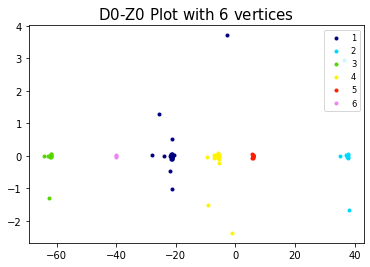

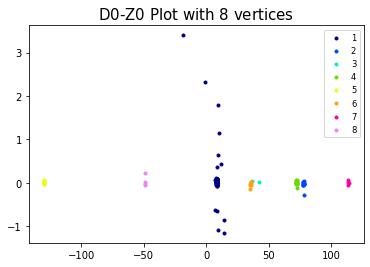

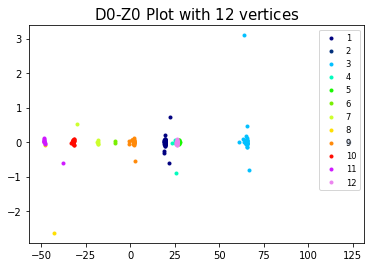

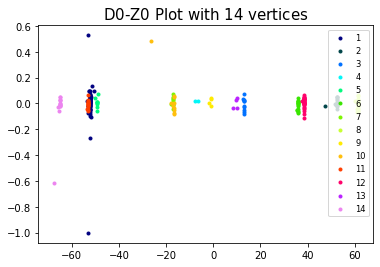

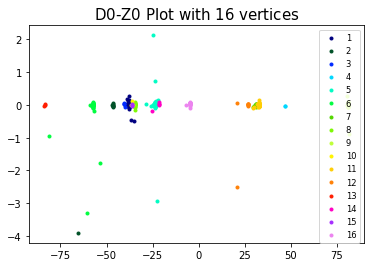

In [12]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import matplotlib.cm as cm

#Let's generate some random X, Y data X = [ [frst group],[second group] ...]
def d0_z0(num_vtx):
    for i in range(event_size):
        if len(truth_vx[i]) == num_vtx:
            num_trk_truth_i = np.bincount(truth_trk_vtxid[i])
            truth_z0_i = np.split(truth_z0[i], np.cumsum(num_trk_truth_i))
            truth_z0_i = truth_z0_i[:-1]

            truth_d0_i = np.split(truth_d0[i], np.cumsum(num_trk_truth_i))
            truth_d0_i = truth_d0_i[:-1]
            break
    X = truth_z0_i
    Y = truth_d0_i
    labels = range(1,len(X)+1)
    colors = cm.rainbow(np.linspace(0, 1, len(X)))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for x,y,c,lab in zip(X,Y,colors,labels):
            ax.scatter(x,y,color=c,label=lab, marker='.')

    colormap = plt.cm.gist_ncar
    colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
    for t,j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])
    ax.set_title('D0-Z0 Plot with' + '\t' + f'${num_vtx}$ vertices' , fontsize = 15)

    ax_vx.set_xlabel('z0')
    ax_vx.set_ylabel('d0')
    ax.legend(fontsize='small', loc='upper right')
    plt.show()
    
d0_z0(6)
d0_z0(8)
d0_z0(12)
d0_z0(14)
d0_z0(16)

## Truth Match Fraction

In [6]:
# only compare z0 instead of all five track parameters to save computing time.
truth_trk_z0, reco_trk_z0 = [], []

for i in tqdm(range(event_size)):
    num_trk_truth_i = np.bincount(truth_trk_vtxid[i])
    truth_z0_i = np.split(truth_z0[i], np.cumsum(num_trk_truth_i))
    truth_z0_i = truth_z0_i[:-1]
    truth_trk_z0.append(truth_z0_i)
    
    num_trk_reco_i = np.bincount(reco_trk_vtxid[i])
    reco_z0_i = np.split(reco_z0[i], np.cumsum(num_trk_reco_i))
    reco_z0_i = reco_z0_i[:-1]
    reco_trk_z0.append(reco_z0_i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2272.17it/s]


### Arrange Reco track parameter

In [7]:
i = 3
truth_trk_info_tmp = np.vstack([truth_d0[i], truth_z0[i], truth_phi[i], truth_theta[i], truth_qp[i], truth_trk_vtxid[i]]).transpose()
pd.DataFrame(truth_trk_info_tmp, columns=['truth d0', 'truth z0', 'truth phi', 'truth theta', 'truth qp', 'truth vtxid'])

,truth d0,truth z0,truth phi,truth theta,truth qp,truth vtxid
0,-0.038274,-22.535131,2.583022,0.915395,-0.616165,0.0
1,0.009521,-22.696026,-0.258679,0.458266,0.444157,0.0
2,-0.088092,-22.692131,0.050467,0.326066,0.314584,0.0
3,-0.030128,-22.519411,1.993542,0.835452,-1.433590,0.0
4,-0.001914,-22.541300,0.288972,0.916353,-0.274592,0.0
...,...,...,...,...,...,...
85,-0.046163,72.341583,0.096143,2.455612,-1.257196,5.0
86,-0.036685,72.360649,-0.132347,1.584137,1.660338,5.0
87,-0.004564,71.659828,1.609938,0.503760,0.441634,5.0
88,3.060091,106.717613,2.895893,1.282347,1.478191,5.0


In [8]:
i = 3
reco_trk_info_tmp = np.vstack([reco_d0[i], reco_z0[i], reco_phi[i], reco_theta[i], reco_qp[i], reco_trk_vtxid[i]]).transpose()
pd.DataFrame(reco_trk_info_tmp, columns=['reco d0', 'reco z0', 'reco phi', 'reco theta', 'reco qp', 'reco vtxid'])

,reco d0,reco z0,reco phi,reco theta,reco qp,reco vtxid
0,-0.038274,-22.535131,2.583022,0.915395,-0.616165,0.0
1,0.009521,-22.696026,-0.258679,0.458266,0.444157,0.0
2,-0.088092,-22.692131,0.050467,0.326066,0.314584,0.0
3,-0.030128,-22.519411,1.993542,0.835452,-1.433590,0.0
4,-0.001914,-22.541300,0.288972,0.916353,-0.274592,0.0
...,...,...,...,...,...,...
67,0.005083,3.834244,-2.363231,0.801376,-0.976419,2.0
68,0.016408,59.312527,1.685628,2.439966,-0.836265,3.0
69,-0.074785,59.254513,1.079694,1.381377,-1.826155,3.0
70,-0.046163,72.341583,0.096143,2.455612,-1.257196,4.0


In [9]:
reco_new = [reco_trk_info_tmp[a] for a, val in enumerate(truth_z0[i]) if val in reco_z0[i]]
pd.DataFrame(reco_new, columns=['reco d0', 'reco z0', 'reco phi', 'reco theta', 'reco qp', 'reco vtxid'])

IndexError: index 74 is out of bounds for axis 0 with size 72

### Testing if reconstructed tracks from AMVF are assigned to multiple vertices.

In [10]:
repeat = []
for i in tqdm(range(event_size)):
    TF = len(reco_z0[i]) != len(set(reco_z0[i]))
    if TF == True:
        repeat.append(i)
        a = reco_z0[i]
        print(f'In event {i}: reco_trk_z0 : {reco_z0[i]}')
        print('repeated:', [x for n, x in enumerate(a) if x in a[:n]])
        break
#print(f'Number of events that has repeating track parameter: {len(repeat)}')

  0%|                                                                                                                               | 0/10000 [00:00<?, ?it/s]

In event 0: reco_trk_z0 : [46.52651215 46.46850204 46.58597946 46.48980713 46.52893829 46.50936508
 46.61397552 46.53812027 46.57664871 46.46896744 46.48858261 46.50208282
 46.52526855 46.55373383 46.49526215 46.58197784 46.47634506 46.53853226
 46.18807602 46.0799408  46.22522354 45.80142212 46.45804977 46.55991364
 46.43391037 46.29047775 46.48677444 46.39379501 46.54808426 45.51962662
 46.20796967 46.54545212 46.51046371 46.37291336 46.47352219 46.41308594
 46.37277603 46.49201584 46.48981094 46.54244614 46.49445724 46.14766693
 46.43787384 46.53528976 46.5318222  46.48994446 46.29901886 46.60843277
 46.84693527 46.52627182 46.46850204 46.48858261 45.95167542 45.92295456
 46.18807602 46.0799408  45.81942368 45.82003403 45.65630341 46.22522354
 45.71411514 45.80142212 46.43391037 46.29047775 45.66014481 46.39379501
 45.51962662 46.20796967 46.54545212 45.85746002 45.87925339 46.41308594
 46.37277603 46.14766693 46.43787384 46.84693527 46.52627182 90.91513824
 91.76917267 91.69986725 

In [11]:
# define variables
import warnings
warnings.filterwarnings('error')
truth_match_matrix = []

for i in tqdm(range(event_size)):
    reco_z0_i, truth_z0_i, reco_trkweight_i = reco_trk_z0[i], truth_trk_z0[i], reco_trkweight[i]
    match_matrix = np.zeros((len(reco_z0_i), len(truth_z0_i)))
    for j in range(len(reco_z0_i)):
        for k in range(len(truth_z0_i)):
            try:
                match_matrix[j, k] = np.sum([reco_trkweight_i[j][a] for a, val in enumerate(reco_z0_i[j]) if val in truth_z0_i[k]]) / np.sum([reco_trkweight_i[j]])                                                                                                                     
            except Warning:
                print(f'In Event {i} in Vertex {j} weird reco track weight: {reco_trkweight_i[j]}')
                pass
    truth_match_matrix.append(match_matrix)
    

  4%|█████                                                                                                               | 437/10000 [00:03<01:31, 104.24it/s]

In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 417 in Vertex 6 weird reco track weight: [0. 0. 0.]


 15%|████████████████▊                                                                                                  | 1466/10000 [00:12<01:18, 109.30it/s]

In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 1447 in Vertex 7 weird reco track weight: [0. 0. 0.]


 22%|████████████████████████▊                                                                                          | 2161/10000 [00:19<01:16, 102.19it/s]

In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]
In Event 2148 in Vertex 7 weird reco track weight: [0. 0. 0.]


 34%|███████████████████████████████████████▍                                                                            | 3397/10000 [00:30<01:11, 92.69it/s]

In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]
In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]
In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]
In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]
In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]
In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]
In Event 3369 in Vertex 6 weird reco track weight: [0. 0. 0. 0.]


 58%|███████████████████████████████████████████████████████████████████▊                                                | 5845/10000 [00:51<00:44, 93.81it/s]

In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
In Event 5817 in Vertex 1 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

 60%|████████████████████████████████████████████████████████████████████▊                                              | 5984/10000 [00:52<00:34, 116.74it/s]

In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
In Event 5949 in Vertex 3 weird reco track weight: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 6990/10000 [01:02<00:27, 109.41it/s]

In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]
In Event 6977 in Vertex 6 weird reco track weight: [0. 0. 0.]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9656/10000 [01:27<00:02, 122.77it/s]

In Event 9629 in Vertex 5 weird reco track weight: [0. 0. 0. 0. 0.]
In Event 9629 in Vertex 5 weird reco track weight: [0. 0. 0. 0. 0.]
In Event 9629 in Vertex 5 weird reco track weight: [0. 0. 0. 0. 0.]
In Event 9629 in Vertex 5 weird reco track weight: [0. 0. 0. 0. 0.]
In Event 9629 in Vertex 5 weird reco track weight: [0. 0. 0. 0. 0.]
In Event 9629 in Vertex 5 weird reco track weight: [0. 0. 0. 0. 0.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:30<00:00, 110.28it/s]


mean_event= 0.9999994054025306
standard deviation_event= 5.934602163756372e-05


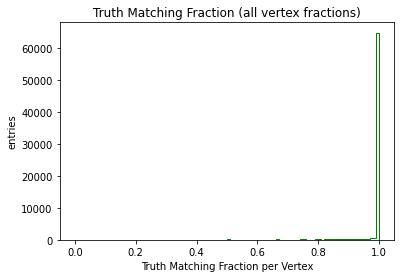

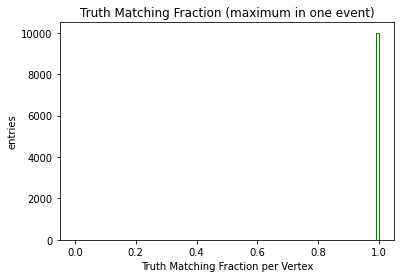

In [12]:
# plotting 
fig_vtx, ax_vtx = plt.subplots()
fig_event, ax_event = plt.subplots()

m_event, m_vtx = [], []
for i in range(len(truth_match_matrix)):
    m_event.append(np.amax(truth_match_matrix[i]))
    for j in range(len(truth_match_matrix[i])):
        m_vtx.append(max(truth_match_matrix[i][j]))
        
(mean, stadev) = norm.fit(m_event)
print('mean_event=', mean)
print('standard deviation_event=', stadev)
bin = np.linspace(0, 1, 101)
ax_event.hist(m_event, bins=bin, color='green', histtype='step', label='number of vertex')
ax_vtx.hist(m_vtx, bins=bin, color='green', histtype='step')

ax_event.set_title('Truth Matching Fraction (maximum in one event)')
ax_vtx.set_title('Truth Matching Fraction (all vertex fractions)')

ax_event.set_xlabel("Truth Matching Fraction per Vertex")
ax_event.set_ylabel("entries")

ax_vtx.set_xlabel("Truth Matching Fraction per Vertex")
ax_vtx.set_ylabel("entries")

plt.show()


## Vertex Classification
 - CLEAN: At least 70% of the total track weight in the reconstructed vertex originates from a single simulated pp interaction.
 - MERGED: Less than 70% of the total track weight in the reconstructed vertex originates from any single simulated pp interaction. Hence, two or more simulated interactions contribute significantly to the accumulated track weight.
 - SPLIT: A single simulated pp interaction contributes the largest track weight to two or more reconstructed vertices. The reconstructed vertex with the largest track pt^2 is classed as either CLEAN or MERGED, whilst the other(s) are labelled SPLIT.
 - FAKE: Fake tracks contribute more weight to the reconstructed vertex than any simulated pp interaction. 

## Event Classification
 - CLEAN/MATCHED: the event contains a CLEAN reconstructed vertex originating from the true HS interaction, and the HS interaction does not contribute more than 50% of the accumulated track weight to any other vertex. 
 - LOWPU (low pile-up): the event contains a MERGED vertex with at least 50% of the accumulated track weight coming from the simulated HS interaction.
 - HIGHPU (high pile-up): the event contains a MERGED vertex with its main contribution coming from a simulated pile-up interaction, and in which the HS interaction contributes between 1% and 50% of the accumulated track weight. 
 - PUREPU (pure pile-up): the event does not contain any reconstructed vertex with at least 1% accumulated track weight from the HS interaction.

In [16]:
m = []
clean, merged, split, fake = 0, 0, 0, 0
matched, high_pu, low_pu, pure_pu = 0, 0, 0, 0
fake = 0 # tested in below cells
reco_num_vtx_total = np.sum(num_vtx_reco)
for i in range(1):
    for j in range(len(truth_match_matrix[i])):
        TruthMatchFraction_vtx = max(truth_match_matrix[i][j])
        if TruthMatchFraction_vtx >= 0.7:
            clean += 1
            if np.sum(reco_HStrkweight[i]) / np.sum(reco_trk_trkweight[i]) <= 0.5:
                matched += 1
        elif TruthMatchFraction_vtx < 0.7 and 
            merged += 1
            if np.sum(reco_HStrkweight[i]) / np.sum(reco_trk_trkweight[i]) > 0.5:
                high_pu += 1
            elif 0.01 < np.sum(reco_HStrkweight[i]) / np.sum(reco_trk_trkweight[i]) <= 0.5:
                low_pu += 1
        elif TruthMatchFraction_vtx < 0.7 and 
            split += 1
        if trk_weight_sum_reco[l][vtx_id_reco[l]]/sum(trk_weight_sum_reco[l]) < 0.01:
            pure_pu += 1
        clean += len([i for i in fraction if i >= 0.7])
        split += len([i for i in fraction if i < 0.7])

        
print('clean:', clean)
print('merged:', merged)
print('split:', split)
print('checking total input of reconstructed vertices:', num_vtx_input_check)

data = {'clean': clean/reco_num_vtx_total, 'merged': merged/reco_num_vtx_total, 'split': split/reco_num_vtx_total, 'fake': fake/reco_num_vtx_total}
pu = list(data.keys())
fra = list(data.values())
plt.bar(pu, fra, fill=False, edgecolor='g', width=0.5)
plt.xlabel('Event Type', fontsize=10)
plt.ylabel('Fraction of Vertices', fontsize=10)
plt.title("Fraction of Vertices in each vertex reconstruction category for AMVF", fontsize=12)
plt.show()

SyntaxError: invalid syntax (959274756.py, line 13)

## Reconstruction & Selection Efficiency
#### To successfully reconstruct a HS, 1 test is done:  `|reco(max(associated number of tracks)) - truth_HS| < 0.1 mm`
 
#### To successfully selection, 1 test is done: `Reconstructed Vertex with max(PT^2) = [max(associated number of tracks) - HS <= 0.1]`
 
#### Local pile-up density: `local pile-up density near a vertex, defined as the number of generated vertices per unit length within a symmetrical ±2 mm longitudinal window`

In [17]:
def dist_cal(list1, list2):
    dist = np.sqrt((list1[0]-list2[0])**2 + (list1[1]-list2[1])**2 + (list1[2]-list2[2])**2)
    return dist
    
def array_row_intersection(a,b):
    tmp=np.prod(np.swapaxes(a[:,:,None],1,2)==b,axis=2)
    return a[np.sum(np.cumsum(tmp,axis=0)*tmp==1,axis=1).astype(bool)]

In [19]:
time_start = time.time()
c = ROOT.TCanvas("fillhist", "title1", 2400, 2400)
TEff_Reco = ROOT.TEfficiency("eff", "HS vertex reconstuction efficiency;Local PU density;HS vertex reconstruction efficiency", 4, 0, 1)
TEff_Sel = ROOT.TEfficiency("eff", "HS vertex selection efficiency;Local PU density;HS vertex reconstruction efficiency", 4, 0, 1)
Long_Reso = ROOT.TEfficiency("reso", "HS longitudinal resolution; Local PU density; longitudinal resolution [mm]", 4, 0, 1)
Tran_Reso = ROOT.TEfficiency("reso", "HS transverse resolution; Local PU density; transverse resolution [mm]", 4, 0, 1)

long_window = 2
for i in range(event_size):
    
    # Prepare the data
    truth_vtx_i, truth_HSvtx_i, truth_HStrk_i = truth_vtx_info[i], truth_HSvtx[i], truth_HStrk[i]
    reco_vtx_i, reco_trk_i, reco_HSvtx_i = reco_vtx_info[i], reco_trk_info[i], reco_HSvtx[i]
    
    # localPUDensity
    long_dist = truth_vz[i]
    long_dist = [np.abs(a-long_dist[0]) for a in long_dist[1:]] 
    nVtxInWindow = len([a for a in long_dist if a < long_window]) 
        
    localPUDensity_i = nVtxInWindow/(long_window * 2)
    
    #Reco Test
    num_trk_associated = []

    for k in range(len(reco_trk_i)):
        # trk_common = [a for a in trk_reco[i][j] if a in trk_truth[i][j]]
        num_trk_associated.append(len(array_row_intersection(truth_HStrk_i, reco_trk_i[k])))
        
    num_trk_associated, reco_vtx_i = zip(*sorted(zip(num_trk_associated, reco_vtx_i), reverse=True))
    bestRecoHSvtx_truth = reco_vtx_i[0]
    
    hs_dist = dist_cal(truth_HSvtx_i, bestRecoHSvtx_truth)

    Reco = hs_dist <= 0.1 
    Sel = bestRecoHSvtx_truth == reco_HSvtx_i
    TEff_Reco.Fill(Reco, localPUDensity_i)
    TEff_Sel.Fill(Reco and Sel, localPUDensity_i)
    
    LongDist = truth_HSvtx_i[2] - reco_HSvtx_i[2]
    TranDist = np.sqrt( (truth_HSvtx_i[0] - reco_HSvtx_i[0]) ** 2 + (truth_HSvtx_i[1] - reco_HSvtx_i[1]) ** 2 )
    
    Long_Reso.Fill(LongDist, localPUDensity_i)
    Tran_Reso.Fill(TranDist, localPUDensity_i)
c.Divide(2, 2)
c.cd(1); TEff_Reco.Draw()
c.cd(2); TEff_Sel.Draw()
c.cd(3); Long_Reso.Draw()
c.cd(4); Tran_Reso.Draw()
c.Draw()

time_elapsed = (time.time() - time_start)
print('time_elapsed:',time_elapsed, 'seconds')

True 0.0


ValueError: void TEfficiency::Fill(bool bPassed, double x, double y = 0, double z = 0) =>
    ValueError: could not convert argument 1 (boolean value should be bool, or integer 1 or 0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fillhist
